In [165]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
# import cf_xarray as cfxr
# import cftime as cfdt
# import pandas as pd
# from datetime import datetime as dt
# from datetime import timedelta as td
import datetime as dt
import glob

import cordex as cx
import xarray as xr

import pyremo as pr

# import xclim as xc


# import sys, os
# import numpy as np
# from urllib.request import urlopen
# import json
# import cmor

# import iteration_utilities
# from pyhomogenize.time_control import time_control

In [167]:
from dask.distributed import Client

client = Client()
client

/mnt/lustre01/pf/g/g300100/kernels/mypython3/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45913 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:45913/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:45913/status,Workers: 4
Total threads: 4,Total memory: 10.39 GiB
Comm: tcp://127.0.0.1:37588,Workers: 4
Dashboard: http://127.0.0.1:45913/status,Total threads: 4
Started: Just now,Total memory: 10.39 GiB
Comm: tcp://127.0.0.1:33577,Total threads: 1
Dashboard: http://127.0.0.1:40053/status,Memory: 2.60 GiB
Nanny: tcp://127.0.0.1:44839,


### Define important functions

In [168]:
def open_mfdataset(
    files,
    use_cftime=True,
    parallel=True,
    data_vars="minimal",
    chunks={"time": 1},
    coords="minimal",
    compat="override",
    drop=None,
    preprocess=None,
    **kwargs,
):
    """optimized function for opening large cf datasets.

    based on https://github.com/pydata/xarray/issues/1385#issuecomment-561920115

    """

    def drop_all_coords(ds):
        if preprocess is not None:
            ds = preprocess(ds, use_cftime=use_cftime)
        return ds.reset_coords(drop=True)

    ds = xr.open_mfdataset(
        files,
        parallel=parallel,
        decode_times=False,
        combine="by_coords",
        preprocess=drop_all_coords,
        decode_cf=False,
        chunks=chunks,
        data_vars=data_vars,
        coords="minimal",
        compat="override",
        **kwargs,
    )
    return xr.decode_cf(ds, use_cftime=use_cftime)

In [169]:
def select_domain(ds, domain):
    domain = cx.cordex_domain(domain)
    # the method=='nearest' approach does not work well with dask
    return ds.sel(
        rlon=slice(domain.rlon.min(), domain.rlon.max()),
        rlat=slice(domain.rlat.min(), domain.rlat.max()),
    )

### Read hourly REMO raw data

In [170]:
pattern = "/work/ch0636/g300046/remo_results_056000/1979/hourly/e056000e_c167_197901.nc"
filenames = glob.glob(pattern)
filenames

['/work/ch0636/g300046/remo_results_056000/1979/hourly/e056000e_c167_197901.nc']

In [171]:
ds = open_mfdataset(filenames, chunks={}, parallel=True, preprocess=pr.preprocess)
ds

<xarray.Dataset>
Dimensions:                     (height2m: 1, rlat: 433, rlon: 433, time: 744)
Coordinates:
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
  * height2m                    (height2m) float64 2.0
    lon                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time                        (time) object 1979-01-01 01:00:00 ... 1979-02...
Data variables:
    rotated_latitude_longitude  |S1 ...
    TEMP2                       (time, height2m, rlat, rlon) float32 dask.array<chunksize=(744, 1, 433, 433), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
    Conventions:          CF-1.6
    history:              preprocessing with pyremo = 0.1.0
    institution:          European Centre for Medium-Range Weather Forecasts
    CDO:                  Climate Data Operators version 1.9.6 (http://mpimet...
    _NCProperties:        version=2,netcdf=4.7.4,hdf5=1.10.6
    forcing_file_format:  NetCDF
    remo_version:         2.0.0
    git_branch:           nc_meta
    git_hash:             c4ee7f4
    system:               Linux eddy3 2.6.32-754.33.1.el6.x86_64 #1 SMP Mon A...

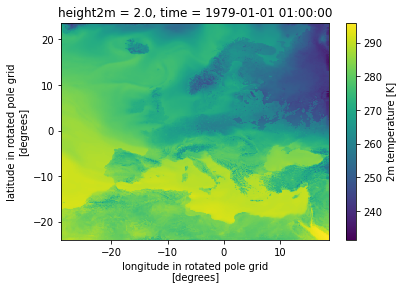

In [172]:
ds.TEMP2.isel(time=0).plot()

#### Example 3-hourly data

#### resample function (alread implemented in pyremo but not in __init__.py)

In [173]:
loffsets = {"3H": dt.timedelta(hours=1, minutes=30), "6H": dt.timedelta(hours=3)}

In [174]:
def _get_loffset(time):
    return loffsets.get(time, None)

In [175]:
def _resample(
    ds, time, time_cell_method="point", label="left", time_offset=True, **kwargs
):
    """Resample a REMO variable."""
    if time_cell_method == "point":
        return ds.resample(time=time, label=label, **kwargs).interpolate("nearest")
    elif time_cell_method == "mean":
        if time_offset is True:
            loffset = _get_loffset(time)
        else:
            loffset = None
        return ds.resample(time=time, label=label, loffset=loffset, **kwargs).mean()
    else:
        raise Exception(f"unknown time_cell_method: {time_cell_method}")

In [176]:
ds_resampled = _resample(
    ds, time="3H", time_cell_method="point", label=None, time_offset=False
)
ds_resampled

<xarray.Dataset>
Dimensions:                     (height2m: 1, rlat: 433, rlon: 433, time: 249)
Coordinates:
  * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
  * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
  * height2m                    (height2m) float64 2.0
    lon                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
    lat                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
  * time                        (time) object 1979-01-01 00:00:00 ... 1979-02...
Data variables:
    rotated_latitude_longitude  |S1 ...
    TEMP2                       (time, height2m, rlat, rlon) float32 dask.array<chunksize=(249, 1, 433, 433), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
    Conventions:          CF-1.6
    history:              preprocessing with pyremo = 0.1.0
    institution:          European Centre for Medium-Range Weather Forecasts
    CDO:                  Climate Data Operators version 1.9.6 (http://mpimet...
    _NCProperties:        version=2,netcdf=4.7.4,hdf5=1.10.6
    forcing_file_format:  NetCDF
    remo_version:         2.0.0
    git_branch:           nc_meta
    git_hash:             c4ee7f4
    system:               Linux eddy3 2.6.32-754.33.1.el6.x86_64 #1 SMP Mon A...

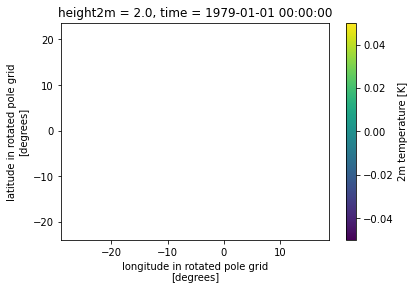

In [177]:
ds_resampled.TEMP2.isel(time=0).plot()

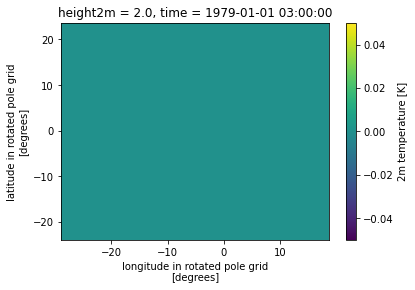

In [178]:
(ds_resampled.TEMP2.isel(time=1) - ds.TEMP2.isel(time=2)).plot()

#### resample method nearest produces a Nan-array for 1979-01-01 00:00:00 (timestep not available in raw data)
#### Clear those empty arrays

In [179]:
def _clear_time_axis(ds):
    for data_var in ds.data_vars:
        ds = ds.dropna(dim="time", how="all")
    return ds

In [180]:
ds_cleared = _clear_time_axis(ds_resampled)
ds_cleared.time

<xarray.DataArray 'time' (time: 248)>
array([cftime.DatetimeGregorian(1979, 1, 1, 3, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1979, 1, 1, 6, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1979, 1, 1, 9, 0, 0, 0, has_year_zero=False),
       ...,
       cftime.DatetimeGregorian(1979, 1, 31, 18, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1979, 1, 31, 21, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeGregorian(1979, 2, 1, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 1979-01-01 03:00:00 ... 1979-02-01 00:00:00

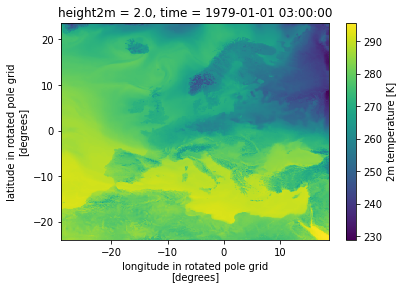

In [181]:
ds_cleared.TEMP2.isel(time=0).plot()

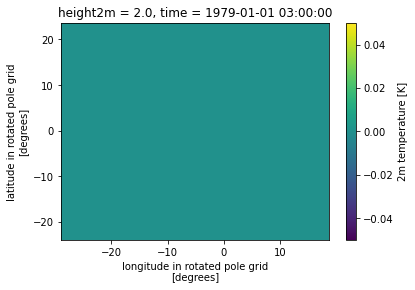

In [182]:
(ds_cleared.TEMP2.isel(time=0) - ds.TEMP2.isel(time=2)).plot()

In [183]:
filename = pr.cmor.cmorize_variable(
    ds_cleared,
    "tas",
    "3hr",
    cx.cordex_cmor_table("remo_example"),
    CORDEX_domain="EUR-11",
    allow_units_convert=True,
)
filename

'CORDEX/CORDEX-CMIP6/CORDEX/GERICS/REMO2-0-0/ECMWF/ECMWF-IFS-LR/historical/r1i1p1f1/3hr/tas/gn/v20211119/tas_3hr_REMO2-0-0_ECMWF-IFS-LR_historical_r1i1p1f1_gn_197901010300-197902010000.nc'

#### Chunk the file

In [184]:
ds_grouped = ds_cleared.groupby("time.dayofyear", squeeze=False)
ds_grouped.groups

{1: [0, 1, 2, 3, 4, 5, 6],
 2: [7, 8, 9, 10, 11, 12, 13, 14],
 3: [15, 16, 17, 18, 19, 20, 21, 22],
 4: [23, 24, 25, 26, 27, 28, 29, 30],
 5: [31, 32, 33, 34, 35, 36, 37, 38],
 6: [39, 40, 41, 42, 43, 44, 45, 46],
 7: [47, 48, 49, 50, 51, 52, 53, 54],
 8: [55, 56, 57, 58, 59, 60, 61, 62],
 9: [63, 64, 65, 66, 67, 68, 69, 70],
 10: [71, 72, 73, 74, 75, 76, 77, 78],
 11: [79, 80, 81, 82, 83, 84, 85, 86],
 12: [87, 88, 89, 90, 91, 92, 93, 94],
 13: [95, 96, 97, 98, 99, 100, 101, 102],
 14: [103, 104, 105, 106, 107, 108, 109, 110],
 15: [111, 112, 113, 114, 115, 116, 117, 118],
 16: [119, 120, 121, 122, 123, 124, 125, 126],
 17: [127, 128, 129, 130, 131, 132, 133, 134],
 18: [135, 136, 137, 138, 139, 140, 141, 142],
 19: [143, 144, 145, 146, 147, 148, 149, 150],
 20: [151, 152, 153, 154, 155, 156, 157, 158],
 21: [159, 160, 161, 162, 163, 164, 165, 166],
 22: [167, 168, 169, 170, 171, 172, 173, 174],
 23: [175, 176, 177, 178, 179, 180, 181, 182],
 24: [183, 184, 185, 186, 187, 188, 189, 19

#### add groups with time lenght equals 1 to previous or next group

In [185]:
groups_dict = {}
i = 1
while i <= len(ds_grouped):
    if len(ds_grouped[i].time) == 1:
        if i - 1 in groups.keys():
            groups_dict[i - 1] = xr.concat(
                [groups_dict[i - 1], ds_grouped[i]], dim="time"
            )
        else:
            groups_dict[i + 1] = ds_grouped[i]
    elif i in groups_dict.keys():
        groups_dict[i] = xr.concat([groups_dict[i], ds_grouped[i]], dim="time")
    else:
        groups_dict[i] = ds_grouped[i]
    i += 1
groups_dict

{1: <xarray.Dataset>
 Dimensions:                     (height2m: 1, rlat: 433, rlon: 433, time: 7)
 Coordinates:
   * rlon                        (rlon) float64 -28.93 -28.82 ... 18.49 18.6
   * rlat                        (rlat) float64 -23.93 -23.82 ... 23.49 23.6
   * height2m                    (height2m) float64 2.0
     lon                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
     lat                         (rlat, rlon) float64 dask.array<chunksize=(433, 433), meta=np.ndarray>
   * time                        (time) object 1979-01-01 03:00:00 ... 1979-01...
 Data variables:
     rotated_latitude_longitude  |S1 ...
     TEMP2                       (time, height2m, rlat, rlon) float32 dask.array<chunksize=(7, 1, 433, 433), meta=np.ndarray>
 Attributes:
     CDI:                  Climate Data Interface version 1.9.6 (http://mpimet...
     Conventions:          CF-1.6
     history:              preprocessing with pyremo = 0.1.0
     institut

In [186]:
for name, group in groups_dict.items():
    filename = pr.cmor.cmorize_variable(
        group,
        "tas",
        "3hr",
        cx.cordex_cmor_table("remo_example"),
        CORDEX_domain="EUR-11",
        allow_units_convert=True,
    )
    print(filename)

CORDEX/CORDEX-CMIP6/CORDEX/GERICS/REMO2-0-0/ECMWF/ECMWF-IFS-LR/historical/r1i1p1f1/3hr/tas/gn/v20211119/tas_3hr_REMO2-0-0_ECMWF-IFS-LR_historical_r1i1p1f1_gn_197901010300-197901012100.nc
CORDEX/CORDEX-CMIP6/CORDEX/GERICS/REMO2-0-0/ECMWF/ECMWF-IFS-LR/historical/r1i1p1f1/3hr/tas/gn/v20211119/tas_3hr_REMO2-0-0_ECMWF-IFS-LR_historical_r1i1p1f1_gn_197901020000-197901022100.nc
CORDEX/CORDEX-CMIP6/CORDEX/GERICS/REMO2-0-0/ECMWF/ECMWF-IFS-LR/historical/r1i1p1f1/3hr/tas/gn/v20211119/tas_3hr_REMO2-0-0_ECMWF-IFS-LR_historical_r1i1p1f1_gn_197901030000-197901032100.nc
CORDEX/CORDEX-CMIP6/CORDEX/GERICS/REMO2-0-0/ECMWF/ECMWF-IFS-LR/historical/r1i1p1f1/3hr/tas/gn/v20211119/tas_3hr_REMO2-0-0_ECMWF-IFS-LR_historical_r1i1p1f1_gn_197901040000-197901042100.nc
CORDEX/CORDEX-CMIP6/CORDEX/GERICS/REMO2-0-0/ECMWF/ECMWF-IFS-LR/historical/r1i1p1f1/3hr/tas/gn/v20211119/tas_3hr_REMO2-0-0_ECMWF-IFS-LR_historical_r1i1p1f1_gn_197901050000-197901052100.nc
CORDEX/CORDEX-CMIP6/CORDEX/GERICS/REMO2-0-0/ECMWF/ECMWF-IFS-LR/hi